<a href="https://www.kaggle.com/code/eugniodias/diamonds-price-predictor?scriptVersionId=126924914" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Diamonds price predictor with RMSE = 511 and r2 score = 98%

The dataset is composed by:

**price**: price in US dollars (\$326--\$18,823)

**carat**: weight of the diamond (0.2--5.01)

**cut**: quality of the cut (Fair, Good, Very Good, Premium, Ideal)

**color**: diamond colour, from J (worst) to D (best)

**clarity**: a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))

**x**: length in mm (0--10.74)

**y**: width in mm (0--58.9)

**z**: depth in mm (0--31.8)

**depth**: total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)

**table**: width of top of diamond relative to widest point (43--95)

## EDA

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import mean_squared_error, r2_score

import seaborn as sns
import xgboost as xgb

Loading the dataset

In [86]:
data = pd.read_csv('/kaggle/input/diamonds/diamonds.csv')
data.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [87]:
data = data.drop(data.columns[0], axis=1)
data.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [88]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


We see that the dataset has 53940 and no missing values.

In [89]:
data.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


We have values of x, y and z equal to 0. We will remove them.

In [90]:
# Removing x, y, z columns with values equal to 0
data = data[(data[['x', 'y', 'z']] != 0).all(axis=1)]
data.describe()

,carat,depth,table,price,x,y,z
count,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000
mean,0.797698,61.749514,57.456834,3930.993231,5.731627,5.734887,3.540046
std,0.473795,1.432331,2.234064,3987.280446,1.119423,1.140126,0.702530
min,0.200000,43.000000,43.000000,326.000000,3.730000,3.680000,1.070000
25%,0.400000,61.000000,56.000000,949.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5323.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


We get the categorical columns.

In [91]:
# Getting the categorical columns
categorical_columns = [col for col in data.columns if data[col].dtype == 'object']
categorical_columns

['cut', 'color', 'clarity']

In [92]:
# Getting the categories of each categorical column
for col in categorical_columns:
    print(col, data[col].unique())

cut ['Ideal' 'Premium' 'Good' 'Very Good' 'Fair']
color ['E' 'I' 'J' 'H' 'F' 'G' 'D']
clarity ['SI2' 'SI1' 'VS1' 'VS2' 'VVS2' 'VVS1' 'I1' 'IF']


We analyse the count of each categorical column.

Text(0, 0.5, 'Count')

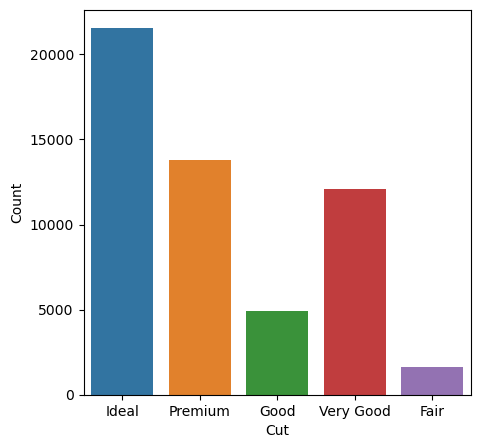

In [93]:
plt.figure(figsize=(5, 5))
sns.countplot(x='cut', data=data)
plt.xlabel('Cut')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

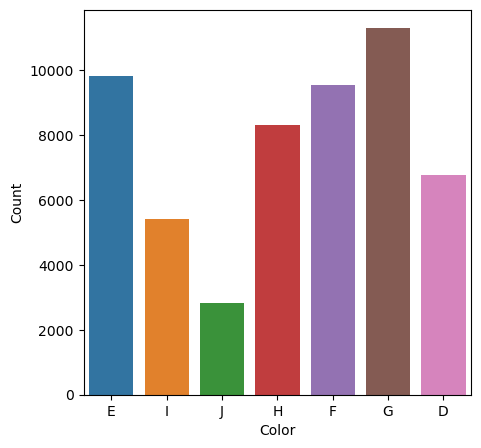

In [94]:
plt.figure(figsize=(5, 5))
sns.countplot(x='color', data=data)
plt.xlabel('Color')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

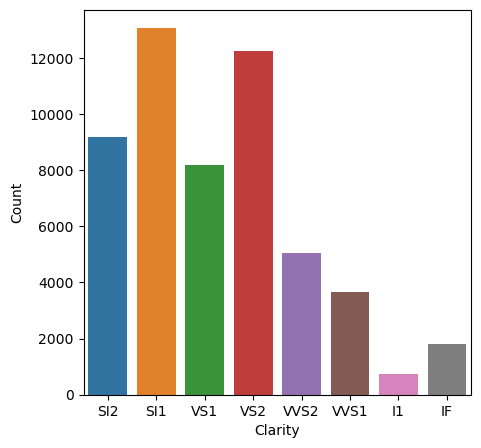

In [95]:
plt.figure(figsize=(5, 5))
sns.countplot(x='clarity', data=data)
plt.xlabel('Clarity')
plt.ylabel('Count')

We do a one-hot encoding of the categorical columns.

In [96]:
# Doing one-hot encoding for the categorical columns
data = pd.get_dummies(data, columns=categorical_columns)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53920 entries, 0 to 53939
Data columns (total 27 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   carat          53920 non-null  float64
 1   depth          53920 non-null  float64
 2   table          53920 non-null  float64
 3   price          53920 non-null  int64  
 4   x              53920 non-null  float64
 5   y              53920 non-null  float64
 6   z              53920 non-null  float64
 7   cut_Fair       53920 non-null  uint8  
 8   cut_Good       53920 non-null  uint8  
 9   cut_Ideal      53920 non-null  uint8  
 10  cut_Premium    53920 non-null  uint8  
 11  cut_Very Good  53920 non-null  uint8  
 12  color_D        53920 non-null  uint8  
 13  color_E        53920 non-null  uint8  
 14  color_F        53920 non-null  uint8  
 15  color_G        53920 non-null  uint8  
 16  color_H        53920 non-null  uint8  
 17  color_I        53920 non-null  uint8  
 18  color_

We now extract the correlation between the price and the other columns.

In [97]:
# Extracting the correlation between price and the other columns
corr = data.corr()['price'].sort_values(ascending=False)
corr

price            1.000000
carat            0.921592
x                0.887231
z                0.868206
y                0.867864
clarity_SI2      0.128354
table            0.127245
color_I          0.097180
cut_Premium      0.095324
color_J          0.081877
color_H          0.058823
cut_Fair         0.018760
clarity_SI1      0.008951
color_G          0.008501
cut_Very Good    0.006829
clarity_I1      -0.000142
cut_Good        -0.000364
clarity_VS2     -0.001105
clarity_VS1     -0.009735
depth           -0.010729
color_F         -0.023941
clarity_IF      -0.049548
clarity_VVS2    -0.052274
color_D         -0.072525
clarity_VVS1    -0.095444
cut_Ideal       -0.097000
color_E         -0.100954
Name: price, dtype: float64

We clearly see that carat, x, y, and z are highly correlated with the price. 

In [98]:
corr_feats = corr.index[1:5]
corr_feats

Index(['carat', 'x', 'z', 'y'], dtype='object')

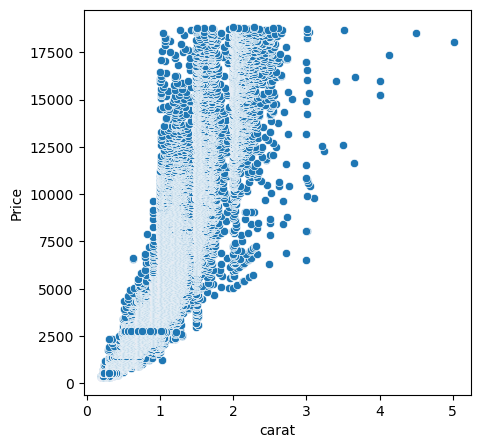

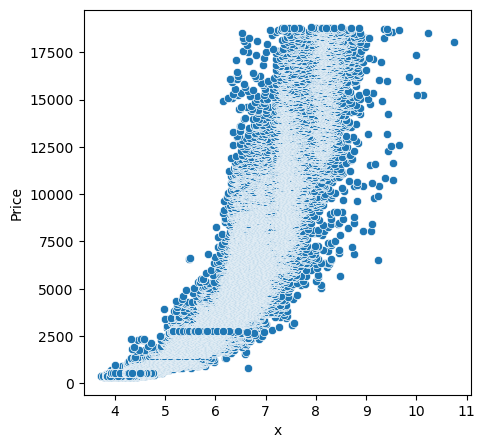

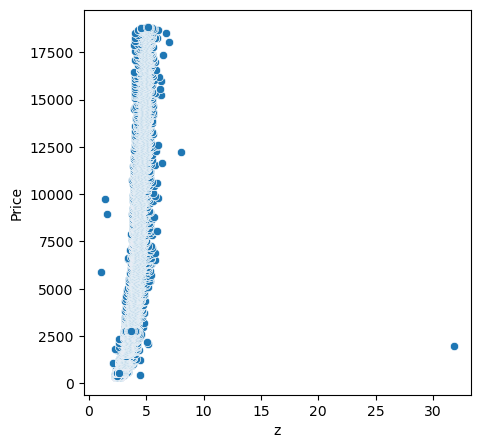

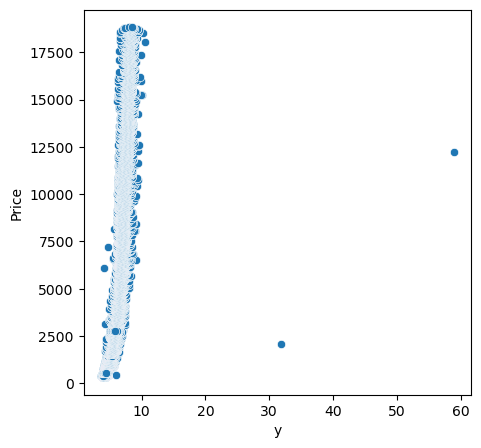

In [99]:
for feat in corr_feats:
    plt.figure(figsize=(5, 5))
    sns.scatterplot(x=feat, y='price', data=data)
    plt.xlabel(feat)
    plt.ylabel('Price')

We analyse those features to remove their outliers

<Figure size 500x500 with 0 Axes>

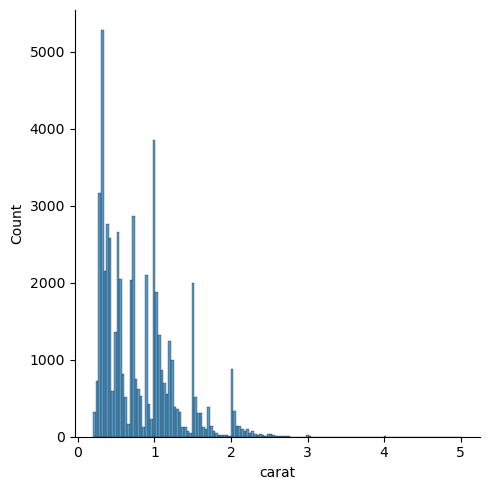

<Figure size 500x500 with 0 Axes>

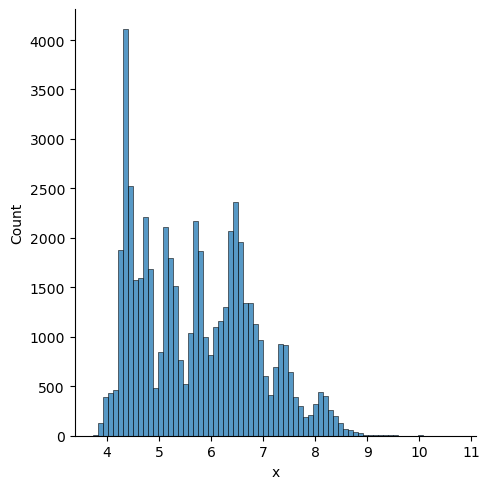

<Figure size 500x500 with 0 Axes>

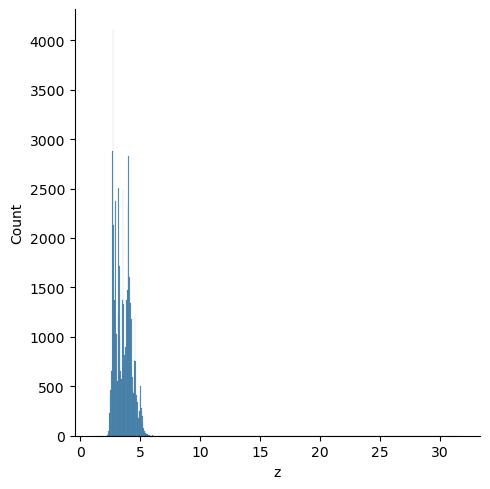

<Figure size 500x500 with 0 Axes>

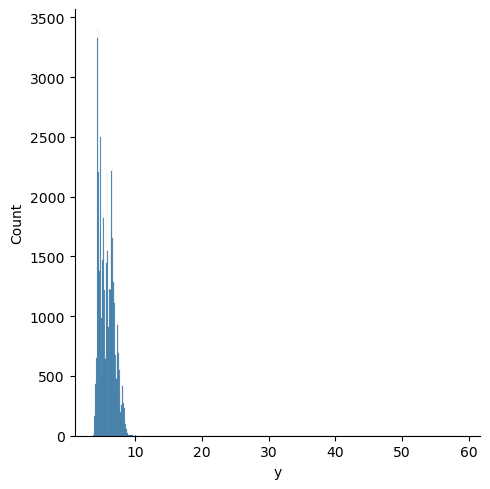

In [100]:
for feat in corr_feats:
    plt.figure(figsize=(5, 5))
    sns.displot(x=feat, data=data)
    plt.xlabel(feat)

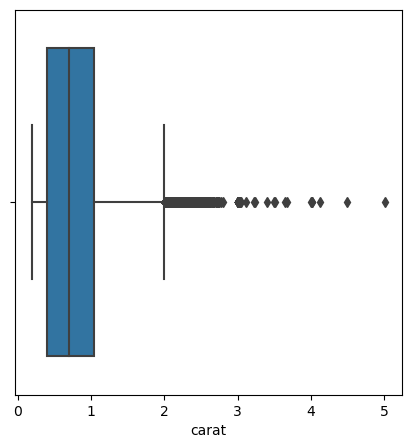

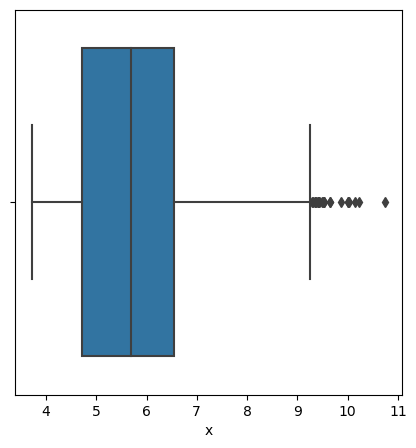

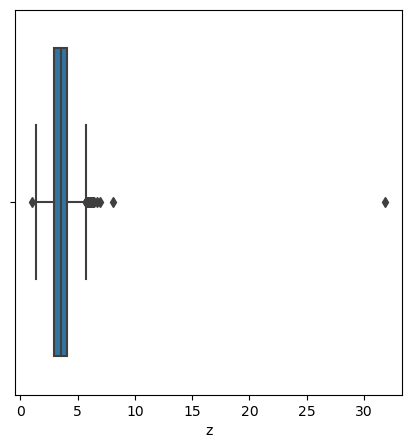

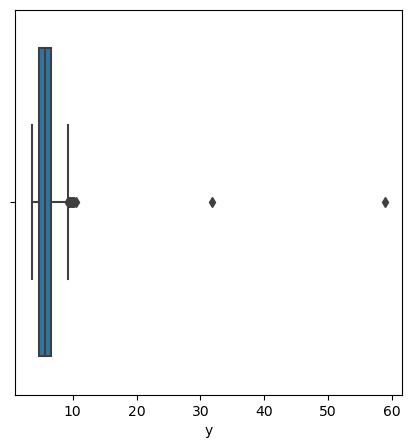

In [101]:
for feat in corr_feats:
    plt.figure(figsize=(5, 5))
    sns.boxplot(x=feat, data=data)
    plt.xlabel(feat)

We'll use the interquatile range to remove the outliers.

In [102]:
# We remove the outliers using the quantile method
for feat in corr_feats:
    q1 = data[feat].quantile(0.25)
    q3 = data[feat].quantile(0.75)
    iqr = q3 - q1
    data = data[(data[feat] >= q1 - 2 * iqr) & (data[feat] <= q3 + 2 * iqr)]

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53667 entries, 0 to 53939
Data columns (total 27 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   carat          53667 non-null  float64
 1   depth          53667 non-null  float64
 2   table          53667 non-null  float64
 3   price          53667 non-null  int64  
 4   x              53667 non-null  float64
 5   y              53667 non-null  float64
 6   z              53667 non-null  float64
 7   cut_Fair       53667 non-null  uint8  
 8   cut_Good       53667 non-null  uint8  
 9   cut_Ideal      53667 non-null  uint8  
 10  cut_Premium    53667 non-null  uint8  
 11  cut_Very Good  53667 non-null  uint8  
 12  color_D        53667 non-null  uint8  
 13  color_E        53667 non-null  uint8  
 14  color_F        53667 non-null  uint8  
 15  color_G        53667 non-null  uint8  
 16  color_H        53667 non-null  uint8  
 17  color_I        53667 non-null  uint8  
 18  color_

In [103]:
data.shape

(53667, 27)

## Building model 

Doing an adversarial validation

In [104]:
# Using random forest to predict the is_train column
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

In [105]:
def adv_validation(data):
    data_train, data_test = train_test_split(data, test_size=0.2)
    data_train['is_train'] = 1
    data_test['is_train'] = 0

    data_adv = pd.concat([data_train, data_test])
    data_adv.drop('price', axis=1, inplace=True)
    features = [col for col in data_adv.columns if col != 'is_train']

    model = RandomForestClassifier(n_estimators=100, max_depth=5)

    skf = StratifiedKFold(n_splits=5, shuffle=True)
    scores = []

    for fold, (train_index, test_index) in enumerate(skf.split(data_adv[features], data_adv['is_train'])):
        X = data_adv[features].iloc[train_index]
        y = data_adv['is_train'].iloc[train_index]
        
        X_train, X_test = data_adv[features].iloc[train_index], data_adv[features].iloc[test_index]
        y_train, y_test = data_adv['is_train'].iloc[train_index], data_adv['is_train'].iloc[test_index]

        model.fit(X_train, y_train)
        preds = model.predict_proba(X_test)[:, 1]

        score = roc_auc_score(y_test, preds)
        print(f"Fold {fold}: AUC score = {score}")
        scores.append(score)

    print(f"Mean AUC score = {np.mean(scores)}")


In [106]:
scores = adv_validation(data)

Fold 0: AUC score = 0.5046540005963239
Fold 1: AUC score = 0.5040907364817291
Fold 2: AUC score = 0.496326834458252
Fold 3: AUC score = 0.5022859214169013
Fold 4: AUC score = 0.5090869973769324
Mean AUC score = 0.5032888980660277


The AUC score lies around 0.5, this shows that the train and test set have similar distributions.

We now fit a xgboost model.

In [107]:
# Running a xgboost using RSME as objective function
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

In [108]:
# Defining stratified k-fold
skf = StratifiedKFold(n_splits=5, shuffle=True)

# Defining the features and the target
features = [col for col in data.columns if col != 'price']
target = 'price'

In [109]:
rmse_list = []
r2_list = []

for fold, (train_index, test_index) in enumerate(skf.split(data[features], data[target])):
    # Split the data
    x_train, x_test = data[features].iloc[train_index], data[features].iloc[test_index]
    y_train, y_test = data[target].iloc[train_index], data[target].iloc[test_index]

    # Train the model
    xgb_model.fit(x_train, y_train)

    # Predict the model
    preds = xgb_model.predict(x_test)
    
    # Evaluate the model
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    print(f"Fold {fold}:")
    print(f"RMSE = {rmse}")
    print(f"R2 = {r2}")

    rmse_list.append(rmse)
    r2_list.append(r2)

print()
print(f"Mean RMSE = {np.mean(rmse_list)}")
print(f"Best RMSE = {np.min(rmse_list)}")
print()
print(f"Mean R2 = {np.mean(r2_list)}")
print(f"Best R2 = {np.max(r2_list)}")

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


Fold 0:
RMSE = 546.3188441410281
R2 = 0.9805282778821314
Fold 1:
RMSE = 533.0565557549972
R2 = 0.9814450324314956
Fold 2:
RMSE = 511.7066036253304
R2 = 0.9829006449096966
Fold 3:
RMSE = 526.3452820610016
R2 = 0.9818974094157001
Fold 4:
RMSE = 561.5601601958814
R2 = 0.9794109282034009

Mean RMSE = 535.7974891556478
Best RMSE = 511.7066036253304

Mean R2 = 0.9812364585684851
Best R2 = 0.9829006449096966
